In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd

# Import the project utils
import sys
sys.path.insert(0, '../utilities/')
import mwc_induction_utils as mwc
import sortseq_utils as sortseq
from sequence_logo import *
mwc.set_plotting_style()

colors_qual=sns.color_palette(
    ['#bf0087', '#e5b600', '#40ac00', '#5233ea', '#bf3800', '#00acac']) # Colors for non-sequential data
sns.set_palette(colors_qual)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Figure 5

Here we use energy matrices and sequence logos to analyze the effects of amino acid mutations on sequence specificity. 

In [20]:
# Load mutant energy matrices
mutant_names = ['Q21M', 'Q21A', 'Y20I']
split_names = ['split1', 'split2', 'split3']

# Load wt matrix
O1_1027_raw = np.load('../../data/models/splits/lacThermoforTO1.npy')
O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
wt_dict = {}
wt_probs_dict = {}
scale_array = []
for k, name in enumerate(split_names):
    array = np.array(sortseq.fix_wt(O1_1027_raw[k], 'AATTGTGAGCGGATAACAATT'))
    array_vals = np.array([val for val in array.ravel() if val != 0])
    scale_array.append(np.mean(array_vals))
    probs = prob_array(array)
    wt_dict[name] = array
    wt_probs_dict[name] = probs

scale = np.mean(scale_array)

# Scale all arrays and get array of probabilities
mut_dict = {}
probs_dict = {}

for mut in mutant_names:
    inner_dict = {}
    inner_probs_dict = {}
    for split in split_names:
        array = np.loadtxt('../../data/models/splits/%s_%s' % (mut, split), skiprows=1, usecols=(1, 2, 3, 4))

        # Fix each matrix so that the lowest energy sequence is fixed at 0, then scale with theoretical parameter.
        array = np.array(sortseq.fix_wt(array, 'AATTGTGAGCGGATAACAATT'))
        array_vals = np.array([val for val in array.ravel() if val != 0])
        scaling_factor = scale/np.mean(array_vals)
        scaled_array = array * scaling_factor
        inner_dict[split] = scaled_array
        np.savetxt('../../data/models/splits/%s_%s_scaled.txt' % (mut, split),\
                   scaled_array, header='base order is A, C, G, T', comments = '#')
        probs = prob_array(scaled_array)
        inner_probs_dict[split] = probs
        np.savetxt('../../data/models/splits/%s_%s_probs.txt' % (mut, split),\
                   probs, header='base order is A, C, G, T', comments = '#')
    mut_dict[mut] = inner_dict
    probs_dict[mut] = inner_probs_dict
    
mut_dict['wt'] = wt_dict
probs_dict['wt'] = wt_probs_dict

## Sequence logos

Energy matrices can provide useful quantitative information, but sequence logos are a quantitative tool that provide a far more satisfying qualitative interpretation of the data. It would be worthwhile to find a scaling factor for the mutant energy matrices that allows us to do this. While this can be done by thermodynamic fitting, here we obtain a scaling factor that gives mutations away from the O1 sequence roughly the same energy penalty as the wild-type lac repressor.

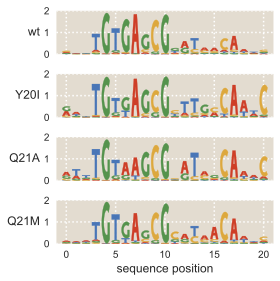

In [97]:
div_colors = sns.diverging_palette(16, 258, s=56, l=51, n=15, sep=2, center='light', as_cmap=True)
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(4, 4))

mut_list = ['wt', 'Y20I', 'Q21A', 'Q21M']

for i, a in enumerate(ax):
    matrix = np.mean([mut_dict[mut_list[i]]['split1'],\
                      mut_dict[mut_list[i]]['split2'],\
                      mut_dict[mut_list[i]]['split3']], axis=0)
    seq_logo(matrix, ax=a, colors=['#ce3e27', '#dda83d', '#55934d', '#4976b7'])
    a.set_ylabel(mut_list[i], rotation = 0, ha = 'right', va = 'center', fontsize=12)
    a.set_xlim(0,22)
    a.set_ylim(0,2)
    a.set_xticks([1, 6, 11, 16, 21])
    a.set_xticklabels(['', '', '', '', ''])

ax[3].set_xlabel('sequence position')    
ax[3].set_xticklabels(['0', '5', '10', '15', '20'])
plt.tight_layout()

plt.savefig('fig5.pdf', bbox_inches='tight')

In [36]:
# Report on probabilities
mut_list = ['wt', 'Q21A', 'Q21M']
split_list = ['split1', 'split2', 'split3']

for mut in mut_list:
    probs_8 = []
    probs_12 = []
    for split in split_list:
        probs_8.append(probs_dict[mut][split][8][2])
        probs_12.append(probs_dict[mut][split][12][0])
    print('%s prob pos 8: %0.2f +/- %0.2f' % (mut, np.mean(np.array(probs_8)), np.std(np.array(probs_8))))
    print('%s prob pos 12: %0.2f +/- %0.2f' % (mut, np.mean(np.array(probs_12)), np.std(np.array(probs_12))))
    
probs_8 = []
probs_12 = []
for split in split_list:
    probs_8.append(probs_dict['Y20I'][split][8][2])
    probs_12.append(probs_dict['Y20I'][split][12][3])
print('Y20I prob pos 8: %0.2f +/- %0.2f' % (np.mean(np.array(probs_8)), np.std(np.array(probs_8))))
print('Y20I prob pos 12: %0.2f +/- %0.2f' % (np.mean(np.array(probs_12)), np.std(np.array(probs_12))))

wt prob pos 8: 0.75 +/- 0.05
wt prob pos 12: 0.49 +/- 0.06
Q21A prob pos 8: 0.86 +/- 0.06
Q21A prob pos 12: 0.63 +/- 0.05
Q21M prob pos 8: 0.61 +/- 0.07
Q21M prob pos 12: 0.50 +/- 0.11
Y20I prob pos 8: 0.79 +/- 0.09
Y20I prob pos 12: 0.63 +/- 0.10


In [39]:
# Take a look at p-values

Q21A_pvals = np.load('../../data/models/splits/Q21A_new_probarrv4_alllogoPvalv6.npy')
Q21M_pvals = np.load('../../data/models/splits/Q21MvWT_new_probarrv3_alllogoPvalv6.npy')
Y20I_pvals = np.load('../../data/models/splits/Y20IvWT_new_probarrv3_alllogoPvalv6.npy')